Installing dependencies

In [ ]:
# only run once
!pip install virtualenv
!virtualenv /content/drive/MyDrive/colab_env
!source /content/drive/MyDrive/colab_env/bin/activate; pip install -q condacolab
import condacolab
condacolab.install(prefix="/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")
!source /content/drive/MyDrive/colab_env/bin/activate; conda install --yes --file /content/drive/MyDrive/2023-2024/Thesis/requirements.txt

In [2]:
# Run this every time
import sys
from pycocotools.coco import COCO
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pickle
import os
import cv2
import PIL
import numpy as np
import requests

from PIL import Image, ImageDraw
from tqdm import tqdm
from google.colab import output
from google.colab import drive


drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

# coco_test = COCO('/content/drive/MyDrive/2023-2024/Thesis/annotations/instances_val2014.json')
# catIds_test = coco_test.getCatIds(catNms=["person"])

# img_IDs_test = coco_test.getImgIds(catIds=catIds_test)

Mounted at /content/drive


In [ ]:

def grayscale_images(annotations, train_or_test):
  #labels = {}
  filepath = '/content/drive/MyDrive/2023-2024/Thesis/{}/{}'
  SPLIT = 'grayscale_{}'.format(train_or_test)
  grayscaled_ims = []

  #need to load images COCO.loadImgs
  for annotation in tqdm(annotations):
      imgName = annotation["file_name"]
      imgId = annotation["id"]
      #print(coco.imgs[i], flush=True)
      imgurl = imgId = annotation["coco_url"]

      # images without people
      # id_num = int(imgId.split('.')[0])
      filename = filepath.format(SPLIT, imgName)
      if not os.path.exists(filename):
        # save blurred image
        # anns = coco.loadAnns(ids=coco.getAnnIds(imgIds=[id_num], catIds=[1], iscrowd=False))
        try:
          img = Image.open(requests.get(imgurl, stream=True).raw)
        except Exception as e:
          print(imgurl)
          print(e)


        grayscale_img = transforms.functional.to_grayscale(img)
        #array_img = np.array(grayscale_img)
        #img = blur_person(anns, i, imgId)
        #print(filename, flush = True)
        grayscale_img.save(fp = filename)
        #labels[filename] = data[i]
        grayscaled_ims.append(filename)
        output.clear()

  return grayscaled_ims

# data_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
#                                      transforms.ToTensor()])
# dataset = ImageFolder(root, transform=data_transform)

In [ ]:
imgs_train = coco_train.loadImgs(img_IDs_train)
grayscale_train = grayscale_images(imgs_train, "train")

100%|██████████| 45174/45174 [2:00:05<00:00,  6.27it/s]


In [ ]:
imgs_test = coco_test.loadImgs(img_IDs_test)
grayscale_test = grayscale_images(imgs_test, "test")

100%|██████████| 21634/21634 [2:19:36<00:00,  2.58it/s]


In [ ]:
import pickle, argparse
import pandas as pd
import os



def id_to_imgpath(id, dir):
    # id is a 12 digit number so pad id with zeros
    zerofilled_id=str(id).zfill(12)

    #/content/drive/MyDrive/2023-2024/Thesis/grayscale_val/COCO_val2014_000000089099.jpg
    return "/content/" + dir + "/COCO_val2014_" + zerofilled_id + ".jpg"
    #return "/content/drive/MyDrive/2023-2024/Thesis/grayscale_" + testorval + "/COCO_" + testorval + "2014_"+zerofilled_id +".jpg"

def create_labels_pickle(filename):
  labels = {} # create dictionary mapping image path to label
  training_labels = {}
  testing_labels = {}
  skin_labels = {"Light":0,"Dark":1}
  images_2014 = pd.read_csv("/content/drive/MyDrive/2023-2024/Thesis/COCO 2014 Val Demographic Annotations/images_val2014.csv")


  # grab only the images containing light (1) or dark (0) labels
  for skin_label in list(skin_labels.keys()):
      print('Creating ' + skin_label + ' data...')
      data = images_2014[list(images_2014['bb_skin'] == skin_label)]
      #print(data)

      for row in range(data.shape[0]):

        imgpath = id_to_imgpath(list(data['id'])[row], filename)
        labels[imgpath] = skin_labels[skin_label]

          # if (not os.path.exists(imgpath)):
          #   print(imgpath)

  with open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_" + filename + ".pkl", 'wb') as handle:
      pickle.dump(labels, handle, protocol=4)

In [ ]:
create_labels_pickle("standard")
img_labels = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard.pkl", "rb"))
print(img_labels)

Creating Light data...
Creating Dark data...
{'/content/standard/COCO_val2014_000000000136.jpg': 0, '/content/standard/COCO_val2014_000000000192.jpg': 0, '/content/standard/COCO_val2014_000000000294.jpg': 0, '/content/standard/COCO_val2014_000000000328.jpg': 0, '/content/standard/COCO_val2014_000000000338.jpg': 0, '/content/standard/COCO_val2014_000000000395.jpg': 0, '/content/standard/COCO_val2014_000000000397.jpg': 0, '/content/standard/COCO_val2014_000000000415.jpg': 0, '/content/standard/COCO_val2014_000000000459.jpg': 0, '/content/standard/COCO_val2014_000000000474.jpg': 0, '/content/standard/COCO_val2014_000000000488.jpg': 0, '/content/standard/COCO_val2014_000000000536.jpg': 0, '/content/standard/COCO_val2014_000000000564.jpg': 0, '/content/standard/COCO_val2014_000000000623.jpg': 0, '/content/standard/COCO_val2014_000000000692.jpg': 0, '/content/standard/COCO_val2014_000000000693.jpg': 0, '/content/standard/COCO_val2014_000000000831.jpg': 0, '/content/standard/COCO_val2014_0000

In [ ]:
create_labels_pickle("grayscale_val")
split_labels("grayscale_val")

Creating Light data...
Creating Dark data...


In [ ]:
create_labels_pickle()

Creating Light data...
Creating Dark data...


In [ ]:
img_labels = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_standard.pkl", "rb"))
print(img_labels)

# img_labels_train = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_train.pkl", "rb"))
# print(img_labels_train)

# img_labels_val = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/skin_labels_val.pkl", "rb"))
# print(img_labels_val)

{'/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000136.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000192.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000294.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000328.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000338.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000395.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000397.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000415.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000459.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000474.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000000488.jpg': 0, '/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_0

In [ ]:
print(len(img_labels_train.keys()))
print(len(img_labels_val.keys()))
print(1360/(9609+1360))

9609
1360
0.1239857781019236


In [ ]:
os.path.exists("/content/drive/MyDrive/2023-2024/Thesis/grayscale_val/COCO_val2014_000000230701.jpg")

True

In [ ]:
import pickle, argparse
import numpy as np

# parser = argparse.ArgumentParser()
# parser.add_argument('--labels', type=str, default=None)
# parser.add_argument('--labels_train', type=str, default=None)
# parser.add_argument('--labels_val', type=str, default=None)
# parser.add_argument('--labels_test', type=str, default=None)
# arg = vars(parser.parse_args())
# print('\n', arg, '\n')
def split_labels(filename):
  arg = {"labels":"/content/drive/MyDrive/2023-2024/Thesis/skin_labels_" + filename + ".pkl",
          "labels_train":"/content/drive/MyDrive/2023-2024/Thesis/skin_labels_" + filename + "_train.pkl",
          "labels_test":"/content/drive/MyDrive/2023-2024/Thesis/skin_labels_" + filename + "_test.pkl",
          "labels_val":"/content/drive/MyDrive/2023-2024/Thesis/skin_labels_" + filename + "_val.pkl"}


  # Load the processed labels
  labels = pickle.load(open(arg['labels'], 'rb'))

  # Do a 60-40 split of train
  N = len(list(labels.keys()))
  N_60 = int(N*0.6)

  # Select images to be added to the 80 split
  np.random.seed(1234)
  keys = list(labels.keys())
  inds_60 = np.random.choice(N, N_60, replace=False)
  keys_60 = np.array(keys)[inds_60] # train
  keys_40 = np.delete(keys, inds_60)

  # split the 40 split into two - val, test
  N = len(keys_40)
  N_50 = int(N*0.5)
  keys = keys_40
  inds_50 = np.random.choice(N, N_50, replace=False)
  keys_50 = np.array(keys)[inds_50] # test
  keys_40 = np.delete(keys, inds_50) # val


  # Create smaller label dictionaries
  labels_train = {k: labels[k] for k in keys_60}
  labels_val = {k: labels[k] for k in keys_40}
  labels_test = {k: labels[k] for k in keys_50}

  with open(arg['labels_train'], 'wb') as handle:
      pickle.dump(labels_train, handle, protocol=4)
  with open(arg['labels_val'], 'wb') as handle:
      pickle.dump(labels_val, handle, protocol=4)
  with open(arg['labels_test'], 'wb') as handle:
      pickle.dump(labels_test, handle, protocol=4)

In [ ]:
split_labels("standard")

In [ ]:
def regular_images(annotations):
  #labels = {}
  filepath = '/content/drive/MyDrive/2023-2024/Thesis/{}/{}'
  SPLIT = 'standard'
  ims = []

  #need to load images COCO.loadImgs
  for annotation in tqdm(annotations):
      imgName = annotation["file_name"]
      imgId = annotation["id"]
      #print(coco.imgs[i], flush=True)
      imgurl = imgId = annotation["coco_url"]

      # images without people
      # id_num = int(imgId.split('.')[0])
      filename = filepath.format(SPLIT, imgName)
      if not os.path.exists(filename):
        img = Image.open(requests.get(imgurl, stream=True).raw)

        #array_img = np.array(grayscale_img)
        #img = blur_person(anns, i, imgId)
        #print(filename, flush = True)
        img.save(fp = filename)
        #labels[filename] = data[i]
        ims.append(filename)
        output.clear()

  return ims

In [ ]:
imgs_test = coco_test.loadImgs(img_IDs_test)
saved_imgs = regular_images(imgs_test)

100%|██████████| 21634/21634 [1:02:25<00:00,  5.78it/s]


In [ ]:
# images are originally 224x224, resize to resolutions 112x112, 56x56, 28x28, 14x14, 7x7
import matplotlib.pyplot as plt
from torchvision.transforms import v2
orig_img = Image.open("/content/drive/MyDrive/2023-2024/Thesis/grayscale_val/COCO_val2014_000000089099.jpg")
resized_imgs = [v2.Resize(size=size)(orig_img) for size in (7, 14, 28, 56, 112)]
for img in resized_imgs:
  img.show()
# transforms.resize()
# try:
#   img = Image.open()
# except Exception as e:
#   print(e)


# resized_img = transforms.functional.to_grayscale(img)

In [ ]:
import cv2
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from IPython.display import display
from tqdm import tqdm
from pycocotools.coco import COCO
import numpy as np

class FullNoBg(object):
    """Mask the background of the image.

    Args:
        coco: coco object.
    """

    def __init__(self, coco):
        self.coco = coco

    def __call__(self, X, y, ID):
        image = X
        ann_ids = self.coco.getAnnIds(int(ID.split('_')[-1].split('.')[0]), iscrowd=False)
        person_ids = self.coco.getAnnIds(int(ID.split('_')[-1].split('.')[0]), catIds=[1], iscrowd=False)
        object_ids = list(set(ann_ids) ^ set(person_ids))
        anns = self.coco.loadAnns(person_ids)
        object_anns = self.coco.loadAnns(object_ids)
        object_mask = np.zeros(image.shape, dtype=np.uint8)
        mask = np.zeros(image.shape, dtype=np.uint8)

        black_image = np.zeros(image.shape, np.uint8)
        channel_count = image.shape[2]
        ignore_mask_color = (255,)*channel_count

        colors = []
        avg_image = np.zeros(image.shape, np.uint)
        dim1, dim2 = image.shape[0], image.shape[1]
        for channel in range(3):
            mean_color = np.mean(image[:,:,channel]).astype(np.uint8)
            layer = np.full((dim1, dim2), mean_color)
            colors.append(layer)
        avg_image = np.stack(colors)
        avg_image = np.moveaxis(avg_image, 0, -1)


        cv2.fillPoly(object_mask, get_mask_polygons(object_anns), ignore_mask_color)
        cv2.fillPoly(mask, get_mask_polygons(anns), ignore_mask_color)
        mask_inverse = np.ones(mask.shape).astype(np.uint8)*255 - mask
        final_image = cv2.bitwise_and(image, mask) + cv2.bitwise_and(black_image, mask_inverse)


def get_mask_polygons(anns):
    polygons = []
    for ann in anns:
        for seg in ann['segmentation']:
            poly = np.array(seg).reshape((len(seg)//2, 2))
            poly = poly.astype(np.int32)
            polygons.append(poly)
    return polygons

def get_avg_color(image):
    avg_color = []
    for channel in range(3):
        mean_color = np.mean(image[:,:,channel]).astype(np.uint8)
        avg_color.append(mean_color)
        return avg_color

def coco_full_nobg(filepath, annotations, split_name):
    print("Full NoBg")
    files = pickle.load(open('../../data/mals/{}.pkl'.format(split_name), 'rb'))
    coco = COCO(annotations)

    for filename in tqdm(files):
        image = cv2.imread(filename)
        ann_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), iscrowd=False)
        person_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), catIds=[1], iscrowd=False)
        object_ids = list(set(ann_ids) ^ set(person_ids))
        anns = coco.loadAnns(person_ids)
        object_anns = coco.loadAnns(object_ids)
        object_mask = np.zeros(image.shape, dtype=np.uint8)
        mask = np.zeros(image.shape, dtype=np.uint8)

        black_image = np.zeros(image.shape, np.uint8)
        channel_count = image.shape[2]
        ignore_mask_color = (255,)*channel_count

        colors = []
        avg_image = np.zeros(image.shape, np.uint)
        dim1, dim2 = image.shape[0], image.shape[1]
        for channel in range(3):
            mean_color = np.mean(image[:,:,channel]).astype(np.uint8)
            layer = np.full((dim1, dim2), mean_color)
            colors.append(layer)
        avg_image = np.stack(colors)
        avg_image = np.moveaxis(avg_image, 0, -1)


        cv2.fillPoly(object_mask, get_mask_polygons(object_anns), ignore_mask_color)
        cv2.fillPoly(mask, get_mask_polygons(anns), ignore_mask_color)
        mask_inverse = np.ones(mask.shape).astype(np.uint8)*255 - mask
        final_image = cv2.bitwise_and(image, mask) + cv2.bitwise_and(black_image, mask_inverse)

def coco_masksegm(filepath, annotations, split_name):
    print("MaskSegm")
    files = pickle.load(open('../../data/mals/{}.pkl'.format(split_name), 'rb'))
    coco = COCO(annotations)

    for filename in tqdm(files):
        image = cv2.imread(filename)
        ann_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), iscrowd=False)
        person_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), catIds=[1], iscrowd=False)
        object_ids = list(set(ann_ids) ^ set(person_ids))
        anns = coco.loadAnns(person_ids)

        mask = np.zeros(image.shape, dtype=np.uint8)
        black_image = np.zeros(image.shape, np.uint8)
        channel_count = image.shape[2]
        ignore_mask_color = (255,)*channel_count

        cv2.fillPoly(mask, get_mask_polygons(anns), ignore_mask_color)
        mask_inverse = np.ones(mask.shape).astype(np.uint8)*255 - mask
        final_image = cv2.bitwise_and(black_image, mask) + cv2.bitwise_and(image, mask_inverse)

        img_name = filename.split('/')[-1]
        new_name = filepath.format(split_name, img_name)
        cv2.imwrite(new_name, final_image)

def coco_maskrect(filepath, annotations, split_name):
    print("MaskRect")
    files = pickle.load(open('../../data/mals/{}.pkl'.format(split_name), 'rb'))
    coco = COCO(annotations)

    for filename in tqdm(files):
        image = cv2.imread(filename)
        ann_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), iscrowd=False)
        person_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), catIds=[1], iscrowd=False)
        anns = coco.loadAnns(ann_ids)
        for ann in anns:
            x, y, width, height = ann['bbox']
            start, end = (int(x), int(y)), (int(x + width), int(y + height))
            final_image = cv2.rectangle(image, end, start, (0, 0, 0), -1)

        img_name = filename.split('/')[-1]
        new_name = filepath.format(split_name, img_name)

        cv2.imwrite(new_name, final_image)


def coco_maskrect_nobg(filepath, annotations, split_name):
    print("MaskRect NoBg")
    coco = COCO(annotations)
    files = pickle.load(open('../../data/mals/{}.pkl'.format(split_name), 'rb'))

    for filename in tqdm(files):
        image = cv2.imread(filename)
        ann_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), iscrowd=False)
        person_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), catIds=[1], iscrowd=False)
        anns = coco.loadAnns(person_ids)
        black_image = np.zeros(image.shape, np.uint8)
        white_image = np.full(image.shape, 255, np.uint8)
        for ann in anns:
            x, y, width, height = ann['bbox']
            x0, y0, x1, y1 = int(x), int(y), int(x + width), int(y + height)
            black_image[y0:y1, x0:x1] = white_image[y0:y1, x0:x1]
        img_name = filename.split('/')[-1]
        new_name = filepath.format(split_name, img_name)
        cv2.imwrite(new_name, black_image)

def coco_masksegm_nobg(filepath, annotations, split_name):
    print("MaskSegm NoBg")
    files = pickle.load(open('../../data/mals/{}.pkl'.format(split_name), 'rb'))
    coco = COCO(annotations)

    for filename in tqdm(files):
        image = cv2.imread(filename)
        ann_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), iscrowd=False)
        person_ids = coco.getAnnIds(int(filename.split('_')[-1].split('.')[0]), catIds=[1], iscrowd=False)
        object_ids = list(set(ann_ids) ^ set(person_ids))
        anns = coco.loadAnns(person_ids)
        object_anns = coco.loadAnns(object_ids)
        object_mask = np.zeros(image.shape, dtype=np.uint8)
        mask = np.zeros(image.shape, dtype=np.uint8)

        black_image = np.zeros(image.shape, np.uint8)
        white_image = np.full(image.shape, 255, np.uint8)
        channel_count = image.shape[2]
        ignore_mask_color = (255,)*channel_count

        colors = []
        avg_image = np.zeros(image.shape, np.uint)
        dim1, dim2 = image.shape[0], image.shape[1]
        for channel in range(3):
            mean_color = np.mean(image[:,:,channel]).astype(np.uint8)
            layer = np.full((dim1, dim2), mean_color)
            colors.append(layer)
        avg_image = np.stack(colors)
        avg_image = np.moveaxis(avg_image, 0, -1)


        cv2.fillPoly(object_mask, get_mask_polygons(object_anns), ignore_mask_color)
        cv2.fillPoly(mask, get_mask_polygons(anns), ignore_mask_color)
        mask_inverse = np.ones(mask.shape).astype(np.uint8)*255 - mask
        final_image = cv2.bitwise_and(black_image, mask) + cv2.bitwise_and(white_image, mask_inverse)

        img_name = filename.split('/')[-1]
        new_name = filepath.format(split_name, img_name)
        cv2.imwrite(new_name, final_image)

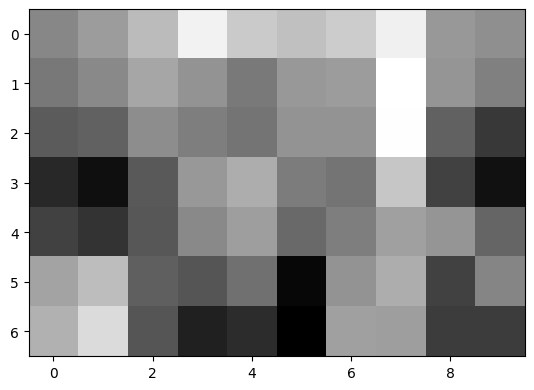

In [ ]:

plt.imshow(resized_imgs[0], cmap = "gray")

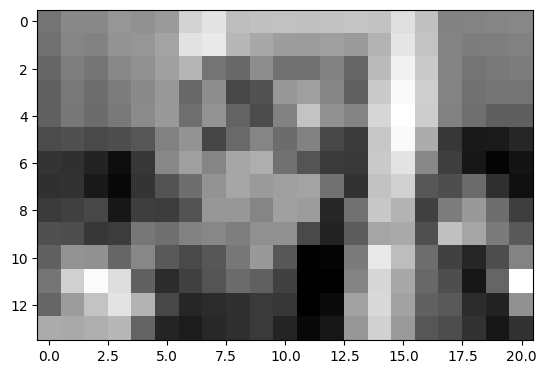

In [ ]:
plt.imshow(resized_imgs[1], cmap = "gray")

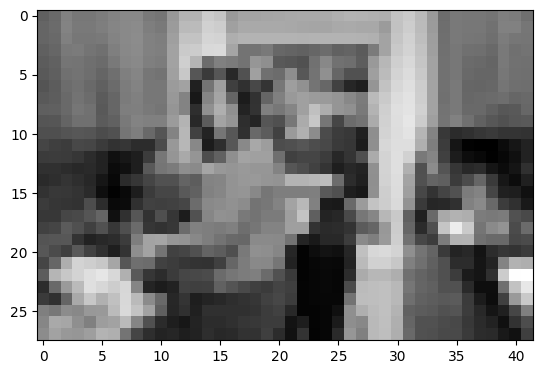

In [ ]:
plt.imshow(resized_imgs[2], cmap = "gray")

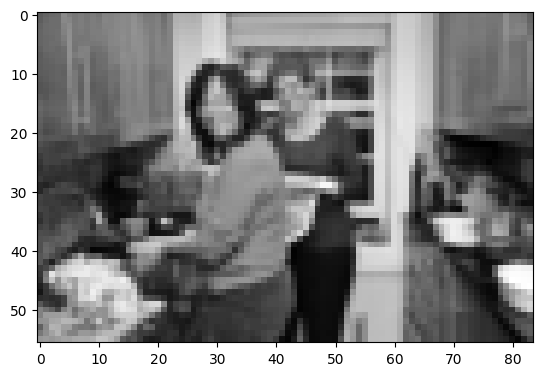

In [ ]:
plt.imshow(resized_imgs[3], cmap = "gray")

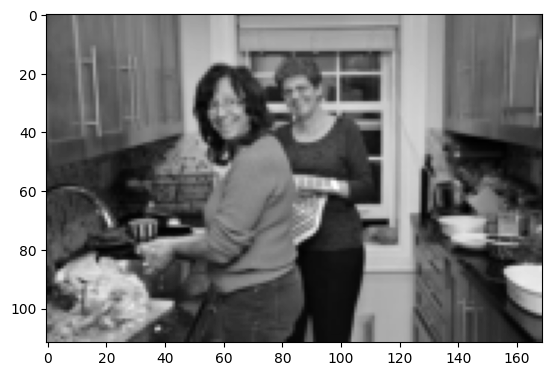

In [ ]:
plt.imshow(resized_imgs[4], cmap = "gray")

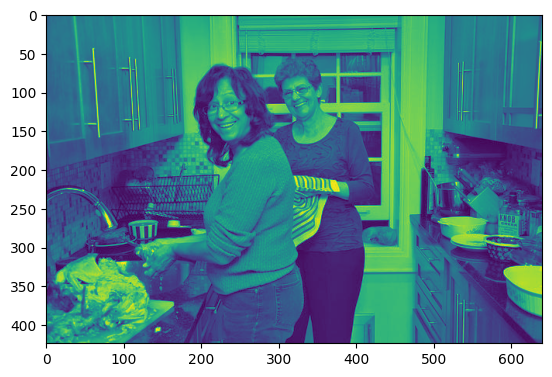

In [ ]:
plt.imshow(orig_img)

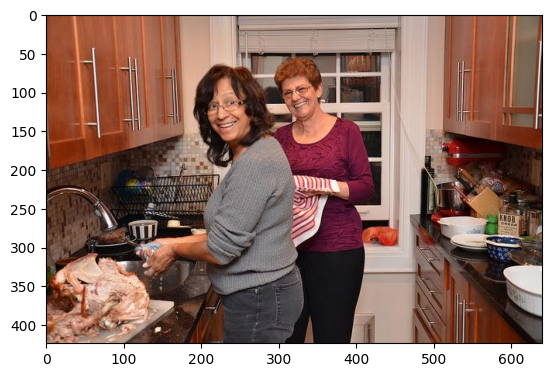

In [ ]:
orig_img_s = Image.open("/content/drive/MyDrive/2023-2024/Thesis/standard/COCO_val2014_000000089099.jpg")
plt.imshow(orig_img_s)

In [ ]:
resized_imgs_s = [v2.Resize(size=size)(orig_img_s) for size in (7, 14, 28, 56, 112)]


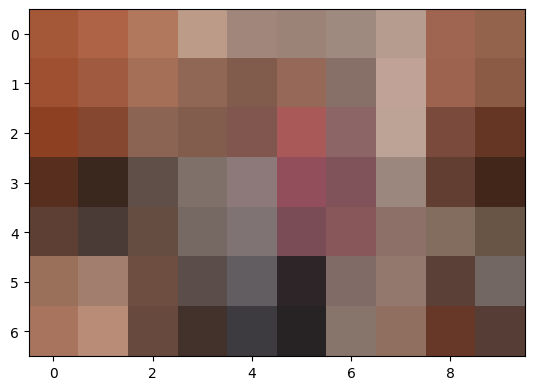

In [ ]:
plt.imshow(resized_imgs_s[0])

In [3]:
import pickle, argparse
import pandas as pd
import os
import json
from collections import defaultdict


# read bboxes from json and put them into a nested dict
#{imgid: {face_box: , lefthand_box:, righthand_box:, etc}}

def create_body_ann_pickle():
  whole_body_annotations = defaultdict(list)
  images_2014 = pd.read_csv("/content/drive/MyDrive/2023-2024/Thesis/COCO 2014 Val Demographic Annotations/images_val2014.csv")
  img_ids = list(images_2014['id'])
  if (not isinstance(img_ids[1], int)):
    return

  with open("/content/drive/MyDrive/2023-2024/Thesis/COCO 2014 Val Demographic Annotations/coco_wholebody_val_v1.0.json", "r") as file:
    coco_whole_body_val = json.load(file)
  for ann in coco_whole_body_val['annotations']:
    if (ann['image_id'] in img_ids):
      whole_body_annotations[ann['image_id']].append({'face_box': ann['face_box'], 'lefthand_box': ann['lefthand_box'], 'righthand_box': ann['righthand_box'],
                                                'body_kpts': ann['keypoints'], 'face_kpts': ann['face_kpts'],
                                                'lefthand_kpts': ann['lefthand_kpts'], 'righthand_kpts': ann['righthand_kpts'],
                                                'foot_kpts': ann['foot_kpts'], 'foot_valid': ann['foot_valid'],
                                                'face_valid': ann['face_valid'],
                                                'lefthand_valid': ann['lefthand_valid'], 'righthand_valid': ann['righthand_valid']})

  with open("/content/drive/MyDrive/2023-2024/Thesis/COCO 2014 Val Demographic Annotations/coco_wholebody_train_v1.0.json", "r") as file:
    coco_whole_body_train = json.load(file)

  for ann in coco_whole_body_train['annotations']:
    if (ann['image_id'] in img_ids):
      whole_body_annotations[ann['image_id']].append({'face_box': ann['face_box'], 'lefthand_box': ann['lefthand_box'], 'righthand_box': ann['righthand_box'],
                                                'body_kpts': ann['keypoints'], 'face_kpts': ann['face_kpts'],
                                                'lefthand_kpts': ann['lefthand_kpts'], 'righthand_kpts': ann['righthand_kpts'],
                                                'foot_kpts': ann['foot_kpts'], 'foot_valid': ann['foot_valid'],
                                                'face_valid': ann['face_valid'],
                                                'lefthand_valid': ann['lefthand_valid'], 'righthand_valid': ann['righthand_valid']})

  with open("/content/drive/MyDrive/2023-2024/Thesis/whole_body_annotations.pkl", 'wb') as handle:
      pickle.dump(whole_body_annotations, handle, protocol=4)


In [4]:
create_body_ann_pickle()

In [6]:
whole_body_anns = pickle.load(open("/content/drive/MyDrive/2023-2024/Thesis/whole_body_annotations.pkl", "rb"))

print(whole_body_anns[136])

[{'face_box': [0.0, 0.0, 0.0, 0.0], 'lefthand_box': [0.0, 0.0, 0.0, 0.0], 'righthand_box': [0.0, 0.0, 0.0, 0.0], 'body_kpts': [38, 181, 2, 0, 0, 0, 37, 166, 2, 0, 0, 0, 10, 171, 2, 0, 0, 0, 4, 246, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'face_kpts': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,